# OCR with Keras, TensorFlow, and Deep Learning

### Install the necessary packages

In [ ]:
!pip install tensorflow==2.2.0

In [1]:
%cd ocr-keras-tensorflow

/content/ocr-keras-tensorflow


### Import Packages

In [2]:
# import the necessary packages
from pyimagesearch.models import ResNet
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import build_montages
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2

Function to display images in Jupyter Notebooks and Google Colab

In [3]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Our OCR dataset helper functions

In [4]:
def load_az_dataset(datasetPath):
	# initialize the list of data and labels
	data = []
	labels = []

	# loop over the rows of the A-Z handwritten digit dataset
	for row in open(datasetPath):
		# parse the label and image from the row
		row = row.split(",")
		label = int(row[0])
		image = np.array([int(x) for x in row[1:]], dtype="uint8")

		# images are represented as single channel (grayscale) images
		# that are 28x28=784 pixels -- we need to take this flattened
		# 784-d list of numbers and repshape them into a 28x28 matrix
		image = image.reshape((28, 28))

		# update the list of data and labels
		data.append(image)
		labels.append(label)

    # convert the data and labels to NumPy arrays
	data = np.array(data, dtype="float32")
	labels = np.array(labels, dtype="int")

	# return a 2-tuple of the A-Z data and labels
	return (data, labels)

In [5]:
def load_mnist_dataset():
	# load the MNIST dataset and stack the training data and testing
	# data together (we'll create our own training and testing splits
	# later in the project)
	((trainData, trainLabels), (testData, testLabels)) = mnist.load_data()
	data = np.vstack([trainData, testData])
	labels = np.hstack([trainLabels, testLabels])

	# return a 2-tuple of the MNIST data and labels
	return (data, labels)

### Training our OCR Model using Keras and TensorFlow

In [6]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"az": "a_z_handwritten_data.csv",
    "model": "handwriting.model",
    "plot": "plot.png"
}

In [7]:
# initialize the number of epochs to train for, initial learning rate,
# and batch size
EPOCHS = 50
INIT_LR = 1e-1
BS = 128

# load the A-Z and MNIST datasets, respectively
print("[INFO] loading datasets...")
(azData, azLabels) = load_az_dataset(args["az"])
(digitsData, digitsLabels) = load_mnist_dataset()

[INFO] loading datasets...
11493376/11490434 [==============================] - 0s 0us/step


In [8]:
# the MNIST dataset occupies the labels 0-9, so let's add 10 to every
# A-Z label to ensure the A-Z characters are not incorrectly labeled
# as digits
azLabels += 10

# stack the A-Z data and labels with the MNIST digits data and labels
data = np.vstack([azData, digitsData])
labels = np.hstack([azLabels, digitsLabels])

# each image in the A-Z and MNIST digts datasets are 28x28 pixels;
# however, the architecture we're using is designed for 32x32 images,
# so we need to resize them to 32x32
data = [cv2.resize(image, (32, 32)) for image in data]
data = np.array(data, dtype="float32")

# add a channel dimension to every image in the dataset and scale the
# pixel intensities of the images from [0, 255] down to [0, 1]
data = np.expand_dims(data, axis=-1)
data /= 255.0

In [9]:
# convert the labels from integers to vectors
le = LabelBinarizer()
labels = le.fit_transform(labels)
counts = labels.sum(axis=0)

# account for skew in the labeled data
classTotals = labels.sum(axis=0)
classWeight = {}

# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.20, stratify=labels, random_state=42)

In [10]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=10,
	zoom_range=0.05,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	fill_mode="nearest")

In [11]:
# initialize and compile our deep neural network
print("[INFO] compiling model...")
opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model = ResNet.build(32, 32, 1, len(le.classes_), (3, 3, 3),
	(64, 64, 128, 256), reg=0.0005)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [12]:
# train the network
print("[INFO] training network...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS,
	class_weight=classWeight,
	verbose=1)

# define the list of label names
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=labelNames))

[INFO] training network...
Epoch 1/50
2765/2765 [==============================] - 183s 66ms/step - loss: 1.8678 - accuracy: 0.8702 - val_loss: 0.5050 - val_accuracy: 0.9167
Epoch 2/50
2765/2765 [==============================] - 184s 66ms/step - loss: 0.9341 - accuracy: 0.9274 - val_loss: 0.5801 - val_accuracy: 0.8686
Epoch 3/50
2765/2765 [==============================] - 184s 66ms/step - loss: 0.8539 - accuracy: 0.9347 - val_loss: 0.5471 - val_accuracy: 0.8891
Epoch 4/50
2765/2765 [==============================] - 184s 67ms/step - loss: 0.8079 - accuracy: 0.9383 - val_loss: 0.5396 - val_accuracy: 0.8904
Epoch 5/50
2765/2765 [==============================] - 184s 66ms/step - loss: 0.7843 - accuracy: 0.9393 - val_loss: 0.5123 - val_accuracy: 0.8959
Epoch 6/50
2765/2765 [==============================] - 183s 66ms/step - loss: 0.7656 - accuracy: 0.9408 - val_loss: 0.5048 - val_accuracy: 0.8986
Epoch 7/50
2765/2765 [==============================] - 183s 66ms/step - loss: 0.7479 - acc

[INFO] serializing network...


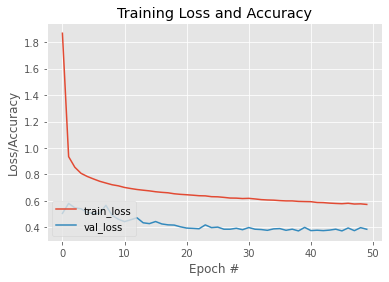

In [13]:
# save the model to disk
print("[INFO] serializing network...")
model.save(args["model"], save_format="h5")

# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])
plt.show()

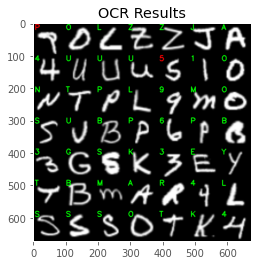

In [14]:
# initialize our list of output test images
images = []

# randomly select a few testing characters
for i in np.random.choice(np.arange(0, len(testY)), size=(49,)):
	# classify the character
	probs = model.predict(testX[np.newaxis, i])
	prediction = probs.argmax(axis=1)
	label = labelNames[prediction[0]]

	# extract the image from the test data and initialize the text
	# label color as green (correct)
	image = (testX[i] * 255).astype("uint8")
	color = (0, 255, 0)

	# otherwise, the class label prediction is incorrect
	if prediction[0] != np.argmax(testY[i]):
		color = (0, 0, 255)

	# merge the channels into one image, resize the image from 32x32
	# to 96x96 so we can better see it and then draw the predicted
	# label on the image
	image = cv2.merge([image] * 3)
	image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
	cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
		color, 2)

	# add the image to our list of output images
	images.append(image)

# construct the montage for the images
montage = build_montages(images, (96, 96), (7, 7))[0]

# show the output montage
plt_imshow("OCR Results", montage)